In [1]:
#!source ../activate_conda.sh
import processor.FCNC_fake_rate_measurement as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
import pandas as pd
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

In [2]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018

samples = get_samples(f_in='samples_testQCD.yaml')

fileset = make_fileset(['testQCD'], samples, redirector=redirector_ucsd, small=True)
print(fileset)

add_processes_to_output(fileset, desired_output)
pt_axis_mu = hist.Bin("pt", r"$p_{T}$ (GeV)", [20., 32., 45., 65., 100.])
eta_axis_mu =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.2, 2.5])
pt_axis_e = hist.Bin("pt", r"$p_{T}$ (GeV)", [0, 25., 35., 45., 65., 100])
eta_axis_e =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.479, 2.5])

desired_output.update({
    "single_mu_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_mu": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_e_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_e, eta_axis_e),
    "single_e": hist.Hist("Counts", dataset_axis, pt_axis_e, eta_axis_e),
    "muons_p": processor.column_accumulator(np.zeros(shape=(0,9)))
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

#get weights and scale data
meta = get_sample_meta(fileset, samples)
my_hists = {}
my_hists['single_mu_fakeable'] = scale_and_merge(output['single_mu_fakeable'], meta, fileset, nano_mapping)
my_hists['single_mu'] = scale_and_merge(output['single_mu'], meta, fileset, nano_mapping)
my_hists['single_e_fakeable'] = scale_and_merge(output['single_e_fakeable'], meta, fileset, nano_mapping)
my_hists['single_e'] = scale_and_merge(output['single_e'], meta, fileset, nano_mapping)
events_p = pd.DataFrame(data=output["muons_p"].value, columns=["pt","conePt","eta","dz","dxy","ptErrRel", "miniPFRelIso_all", "event", "MET_PT"])

{'/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM': ['root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/70000/DE335891-829A-B943-99BE-E5A179F5F3EB.root']}
I'm running now


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

In [3]:
fakeable_mu_hist = output["single_mu_fakeable"]
tight_mu_hist = output["single_mu"]
fakeable_e_hist = output["single_e_fakeable"]
tight_e_hist = output["single_e"]
fakeable_mu_hist_weighted = my_hists["single_mu_fakeable"]
tight_mu_hist_weighted = my_hists["single_mu"]
fakeable_e_hist_weighted = my_hists["single_e_fakeable"]
tight_e_hist_weighted = my_hists["single_e"]

In [4]:
# import uproot
# tree = uproot.open('root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/120000/DBBFA116-54FD-1F49-99EA-A95187A4D14C.root')['Events']
# tree.arrays(['MET_pt'])
def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x

def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

In [5]:
# pt_bins = hist.Bin("pt", r'$P_{T}\ GeV$', [0, 25., 35., 45., 65., 120.])#[[0, 25.],[25., 35.], [35., 45.], [45., 65.], [65., 120.]])
# eta_bins_mu = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.2, 1.2,  2.5])
# eta_bins_e = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.5, 1.5, 2.5])
rebinned_fakeable_mu_hist = fakeable_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist = fakeable_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_fakeable_mu_hist_weighted = fakeable_mu_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist_weighted = fakeable_e_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_tight_mu_hist = tight_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist = tight_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_tight_mu_hist_weighted = tight_mu_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist_weighted = tight_e_hist_weighted#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

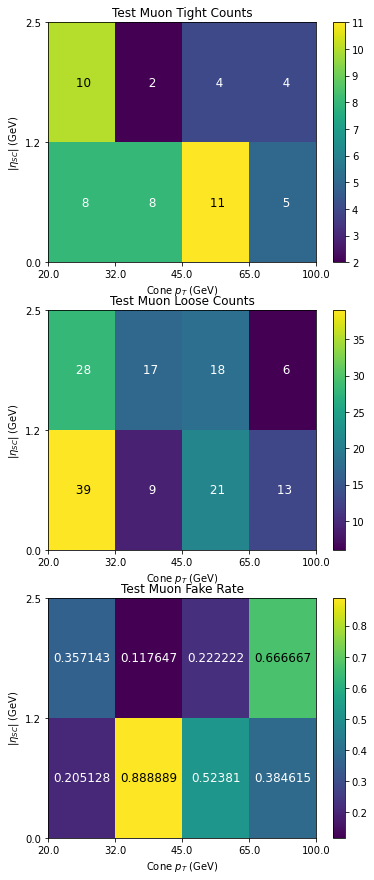

In [6]:
fig, ax = plt.subplots(3, 1, figsize = (6,15))

make_yahist(tight_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Test Muon Tight Counts')


make_yahist(fakeable_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Test Muon Loose Counts')

num_mu = tight_mu_hist.sum('dataset')
denom_mu = (fakeable_mu_hist).sum('dataset')
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[2].set_title('Test Muon Fake Rate')

plt.savefig("/home/users/cmcmahon/public_html/fake_rates/fr_debugging.pdf")
plt.show()

In [8]:
bin_reqs_pt = [(events_p["pt"] > 20) & (events_p["pt"] < 32) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            (events_p["pt"] > 32) & (events_p["pt"] < 45) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            (events_p["pt"] > 45) & (events_p["pt"] < 65) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            (events_p["pt"] > 65) & (events_p["pt"] < 100) & (events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
            (events_p["pt"] > 20) & (events_p["pt"] < 32) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            (events_p["pt"] > 32) & (events_p["pt"] < 45) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            (events_p["pt"] > 45) & (events_p["pt"] < 65) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2)),
            (events_p["pt"] > 65) & (events_p["pt"] < 100) & ((events_p["eta"] > 1.2) | (events_p["eta"] < -1.2))]
len(events_p[bin_reqs_pt[0]])
events_p[bin_reqs_pt[0]]

,pt,conePt,eta,dz,dxy,ptErrRel,miniPFRelIso_all,event,MET_PT
2,30.669834,0.0,-0.302490,-0.001702,-0.000288,0.011335,0.000000,9526436.0,13.936753
4,27.741674,0.0,-0.522827,0.000476,-0.000412,0.009997,0.000000,11089467.0,13.078042
15,29.030134,0.0,0.136749,0.001368,0.000496,0.008074,0.085041,8223890.0,11.177638
17,24.882261,0.0,0.620728,0.002647,0.000210,0.009655,0.000000,6733483.0,11.333877
30,29.254267,0.0,-0.623535,-0.003443,-0.000011,0.010549,0.096175,10536846.0,19.349808
32,21.753752,0.0,-1.049316,-0.009010,0.005394,0.014724,0.004520,10552584.0,12.038274
47,22.368685,0.0,0.851562,-0.001480,0.000735,0.010391,0.000000,9673978.0,19.919518
50,20.704973,0.0,-0.851196,0.000921,-0.001804,0.013206,0.000000,328544.0,18.962660
52,20.605301,0.0,-0.296448,-0.000134,-0.000039,0.008815,0.035285,5315453.0,16.782812
65,22.279369,0.0,0.070358,0.009956,0.000173,0.008241,0.002802,9063568.0,3.125568


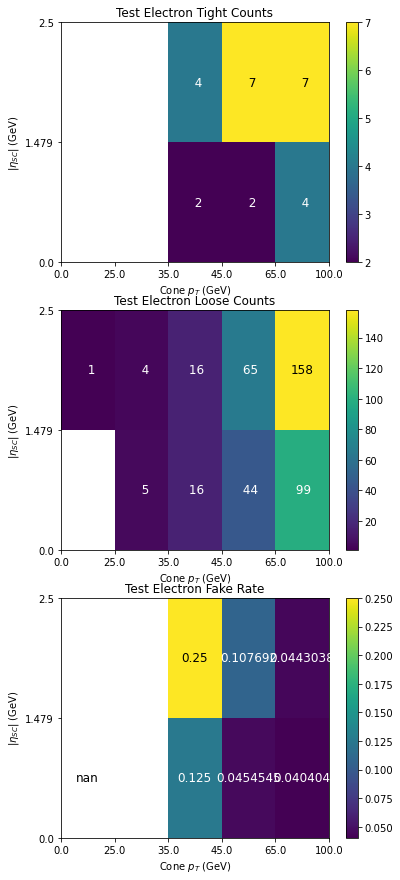

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (6,15))

make_yahist(tight_e_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Test Electron Tight Counts')


make_yahist(fakeable_e_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Test Electron Loose Counts')

num_e = tight_e_hist.sum('dataset')
denom_e = (fakeable_e_hist).sum('dataset')
divide_2D_hist(num_e, denom_e).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[2].set_title('Test Electron Fake Rate')

plt.show()

In [ ]:
plt.figure("QCD_mu_fake_rate", figsize = (10,10))
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('QCD Muon Fake Rate')
plt.show()

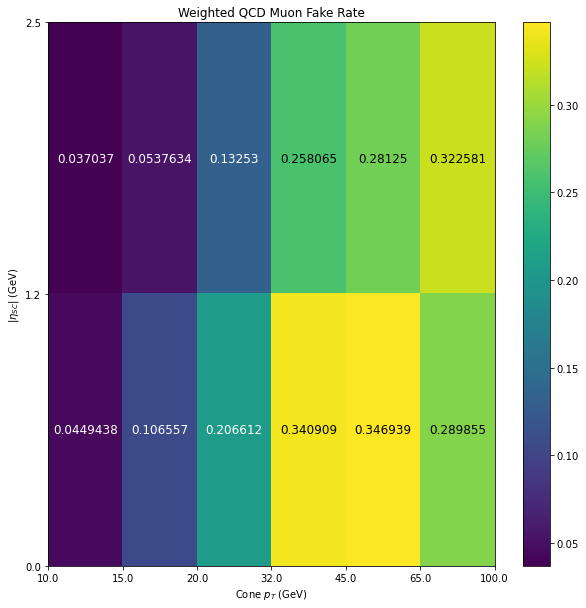

In [35]:
plt.figure("QCD_mu_fake_rate_weighted", figsize = (10,10))
divide_2D_hist(num_mu_weighted, denom_mu_weighted).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('Weighted QCD Muon Fake Rate')
plt.show()

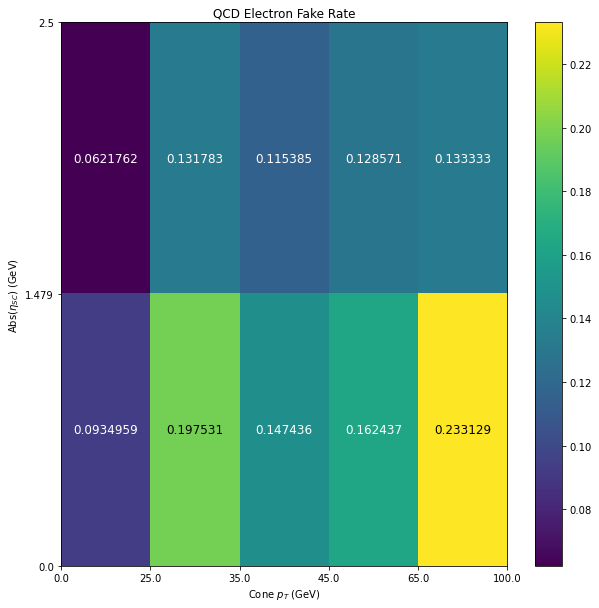

In [38]:
plt.figure("QCD_e_fake_rate", figsize = (10,10))
e_fake_rate = divide_2D_hist(num_e, denom_e)
e_fake_rate.plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'Abs($\eta_{SC}$) (GeV)')
plt.title('QCD Electron Fake Rate')
plt.show()
e_fake_rate.to_json("e_fake_rate.json")

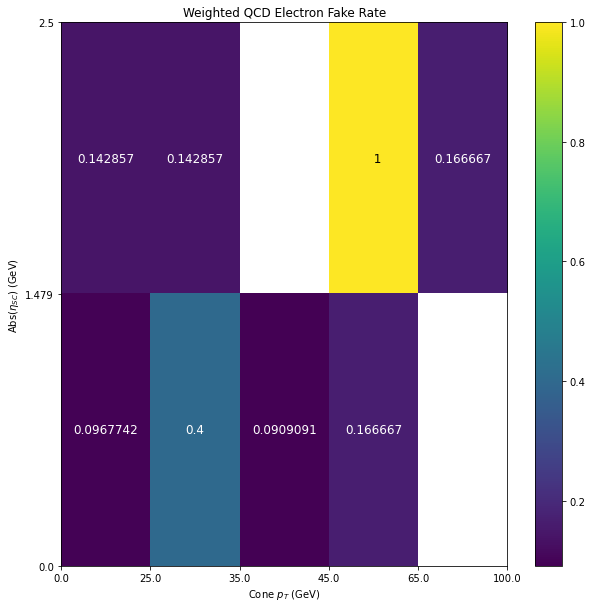

In [37]:
plt.figure("QCD_e_fake_rate_weighted", figsize = (10,10))
divide_2D_hist(num_e_weighted, denom_e_weighted).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'Abs($\eta_{SC}$) (GeV)')
plt.title('Weighted QCD Electron Fake Rate')
plt.show()

In [11]:
x1 = a.sum('dataset')
x1_axis_0 = x1.axes()[0].name
x1_axis_1 = x1.axes()[1].name
x1_y = Hist2D.from_bincounts(x1.values()[()].T, (x1.axis(x1_axis_0).edges(), x1.axis(x1_axis_1).edges()))
hist.plot2d(x1, xaxis = x1.axes()[0].name)
plt.figure('test2', figsize = (7,7))
x1_y.plot(show_counts=True)
plt.draw()

NameError: name 'a' is not defined